# Homework 6 (more of a tutorial, really)

As I was browsing through Kaggle the other day, I came upon a brand new dataset from the University of Puerto Rico, which contains images of bees entering their hive.  The task is to determine automatically which bees are carrying pollen.  Your job will be to develop a convolutional neural network that performs this task.  

## 1. Load Data (0 pts)

First, we need to load the bee data, which is included along with this homework.  Fortunately, the authors of the Kaggle dataset provided a nice set of files which will do this for us, which I have reproduced below

In [1]:
import glob, os 
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
path="images/"
imlist= glob.glob(os.path.join(path, '*.jpg'))

In [3]:
def dataset(file_list,size=(300,180),flattened=False):
    data = []
    for i, file in enumerate(file_list):
        image = io.imread(file)
        image = transform.resize(image, size, mode='constant')
        if flattened:
            image = image.flatten()

        data.append(image)

    labels = [1 if f.split("/")[-1][0] == 'P' else 0 for f in file_list]

    return np.array(data), np.array(labels)

In [4]:
# Load the dataset (may take a few seconds)
X,y=dataset(imlist)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)


/home/erik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [5]:
# X has the following structure: X[imageid, y,x,channel]
print('X: ',X.shape)  # data
print('y: ',y.shape)  # target

print('Class 0: ',sum(y==0))
print('Class 1: ',sum(y==1))
print('Total  : ',len(y))

X:  (714, 300, 180, 3)
y:  (714,)
Class 0:  345
Class 1:  369
Total  :  714


We can plot a couple of the images below.  If you check out a couple of these, you will see that the visible difference when bees carry pollen is the presence of large fluffy balls of pollen on their back legs.

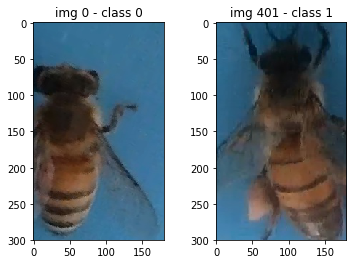

In [6]:
fig, axes = plt.subplots(1,2)
k=0
plt.sca(axes[0])
plt.imshow(X[k])
plt.title('img {} - class {}'.format(k, y[k]))

k=401
plt.sca(axes[1])
plt.imshow(X[k])
plt.title('img {} - class {}'.format(k, y[k]));

## 2. A convolutional network architecture for bee classification (40 pts)

**Implement a 2D convolutional neural network using Keras.  You are free to choose whatever network architecture you like.**

You can find all the relevant syntax for implementing such a network [here](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py), the Keras convnet example for MNIST.

*(For the sake of comparison, I will share the one that I used:*

Layer 1: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 2: 4x4 Max-pooling layer

Layer 3: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 4: 4x4 Max-pooling layer

Layer 5: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 6: 4x4 Max-pooling layer

Layer 7: Flattening layer

Layer 8: Dropout layer with 0.2 dropout probability

Layer 9: 1 node sigmoid layer


In [7]:
import keras
import keras.models as km
import keras.layers as kl

import numpy as np

input_shape = ((300,180,3))

model = km.Sequential()

model.add(kl.Conv2D(10, kernel_size=(10, 10), activation='relu', input_shape=input_shape))
model.add(kl.MaxPooling2D(pool_size=(2, 2)))
model.add(kl.Conv2D(10, (10, 10), activation='relu'))
model.add(kl.AveragePooling2D(pool_size=(4, 4)))
model.add(kl.Flatten())
model.add(kl.Dropout(0.37))
model.add(kl.Dense(1, activation='sigmoid'))




Using TensorFlow backend.


## 3. Fitting the CNN to data (20 pts)

Compile your model, using a binary crossentropy loss function and an optimizer of your choosing (RMSprop worked well for me).  Select a batch size and number of epochs, and fit your model to the training data, while also keeping track of the test set accuracy.

**Plot the training and test accuracy of your model at each epoch.  Comment on whether you think the model is being overfit.**

In [8]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

batch_size = 15                       #! Specify a batch size
epochs= 10                            #! Specify an epoch  
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test,y_test))

#! Plot test and training accuracy (note that the history.history object is a dictionary containing relevant info)

Train on 571 samples, validate on 143 samples
Epoch 1/10
571/571 [==============================] - 57s 100ms/step - loss: 0.6922 - acc: 0.6305 - val_loss: 0.6812 - val_acc: 0.6364
Epoch 2/10
571/571 [==============================] - 57s 99ms/step - loss: 0.5563 - acc: 0.7426 - val_loss: 0.5935 - val_acc: 0.7972
Epoch 3/10
571/571 [==============================] - 57s 100ms/step - loss: 0.4872 - acc: 0.8144 - val_loss: 0.5956 - val_acc: 0.6434
Epoch 4/10
571/571 [==============================] - 57s 100ms/step - loss: 0.4395 - acc: 0.8109 - val_loss: 0.4537 - val_acc: 0.8322
Epoch 5/10
571/571 [==============================] - 60s 105ms/step - loss: 0.4073 - acc: 0.8284 - val_loss: 1.0592 - val_acc: 0.5455
Epoch 6/10
571/571 [==============================] - 57s 100ms/step - loss: 0.3840 - acc: 0.8441 - val_loss: 0.4108 - val_acc: 0.8182
Epoch 7/10
571/571 [==============================] - 57s 100ms/step - loss: 0.4037 - acc: 0.8144 - val_loss: 0.3957 - val_acc: 0.8462
Epoch 8/10

Text(0.5, 0, 'Epoch')

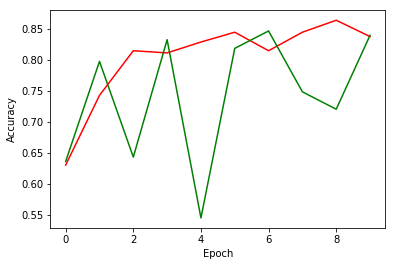

In [9]:

plt.plot(history.history['acc'], 'r')
plt.plot(history.history['val_acc'], 'g')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
            

I would say the model is likely being over-fit, the levelling off of the red training accuracy line is in sharp contrast with the jagged shape of the validation accuracy line.

## 4. Model evaluation (20 pts)

Now that you have a trained model, make a prediction for the test set (model.predict is a useful function for this).  **Compute and display a confusion matrix.  Select and display an example from the test set of a true positive, a true negative, a false positive, and a false negative.  Speculate on the reasons behind misclassification for images that your model predicted incorrectly**.

In [10]:
prediction = model.predict(X_test)

Confusion Matrix: 
[[65.  7.]
 [16. 55.]]



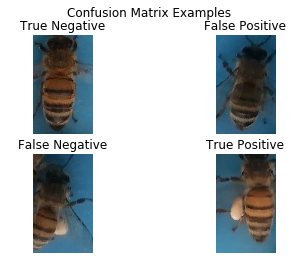

In [11]:
prediction = prediction.flatten()
binary_prediction = []
cm = np.zeros((2,2))
im_indices = [[[],[]], [[],[]]]

for val in prediction:
    if val < 0.5:
        binary_prediction.append(0)
    else:
        binary_prediction.append(1)
for i,(p,y) in enumerate(zip(binary_prediction, y_test)):
    cm[y][p] += 1
    im_indices[y][p].append(i)
print("Confusion Matrix: ")
print(cm)
print()
true_negs = im_indices[0][0]
false_positives = im_indices[0][1]
false_negs = im_indices[1][0]
true_positives = im_indices[1][1]


fig, axes = plt.subplots(2,2)
titles = [["True Negative", "False Positive"], ["False Negative", "True Positive"]]
for i in range(2):
    for j in range(2):
        idx = 2*j +i
        plt.sca(axes[i][j])
        plt.imshow(X_test[im_indices[i][j][0]])
        plt.title(titles[i][j])
axes = axes.flatten()
for ax in axes:
    ax.axis('off')
plt.suptitle("Confusion Matrix Examples")
plt.show()


I would venture that on occassion the classifier is keying in on the bee's own innate fuzziness arround its thorax when it produced false positives. I'm guessing the false negatives likely have smaller pollen balls attached to them.